In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string

In [2]:
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Load the training data
train_location = "C:\\Users\\ompan\\OneDrive\\Desktop\\Internship\\Genre Classification Dataset\\train_data.txt"
train_data = pd.read_csv(train_location, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')

# Display basic statistics of the training data
print(train_data.describe())

                                 Title    Genre  \
count                            54214    54214   
unique                           54214       27   
top      Oscar et la dame rose (2009)    drama    
freq                                 1    13613   

                                              Description  
count                                               54214  
unique                                              54086  
top      Grammy - music award of the American academy ...  
freq                                                   12  


In [4]:
# Load the test data
test_location = "C:\\Users\\ompan\\OneDrive\\Desktop\\Internship\\Genre Classification Dataset\\test_data.txt"
test_data = pd.read_csv(test_location, sep=':::', names=['Id', 'Title', 'Description'], engine='python')

# Display the first few rows of the test data
print(test_data.head())


   Id                          Title  \
0   1          Edgar's Lunch (1998)    
1   2      La guerra de papá (1977)    
2   3   Off the Beaten Track (2010)    
3   4        Meu Amigo Hindu (2015)    
4   5             Er nu zhai (1955)    

                                         Description  
0   L.R. Brane loves his life - his car, his apar...  
1   Spain, March 1964: Quico is a very naughty ch...  
2   One year in the life of Albin and his family ...  
3   His father has died, he hasn't spoken with hi...  
4   Before he was known internationally as a mart...  


In [5]:
# Text preprocessing
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()
    return text


# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

In [6]:
# Use TF-IDF for feature extraction
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])


In [7]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, train_data['Genre'], test_size=0.2, random_state=42)

In [8]:
# Check the shapes after splitting
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


X_train shape: (43371, 124210)
X_val shape: (10843, 124210)
y_train shape: (43371,)
y_val shape: (10843,)


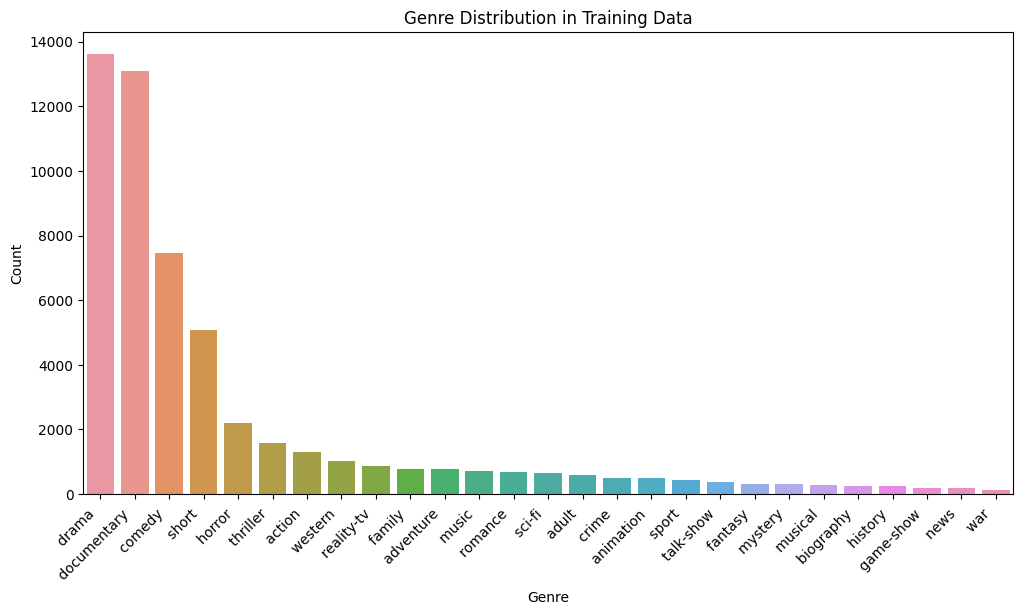

In [9]:
# Visualize genre distribution in training data
plt.figure(figsize=(12, 6))
sns.countplot(data=train_data, x='Genre', order=train_data['Genre'].value_counts().index)
plt.title('Genre Distribution in Training Data')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

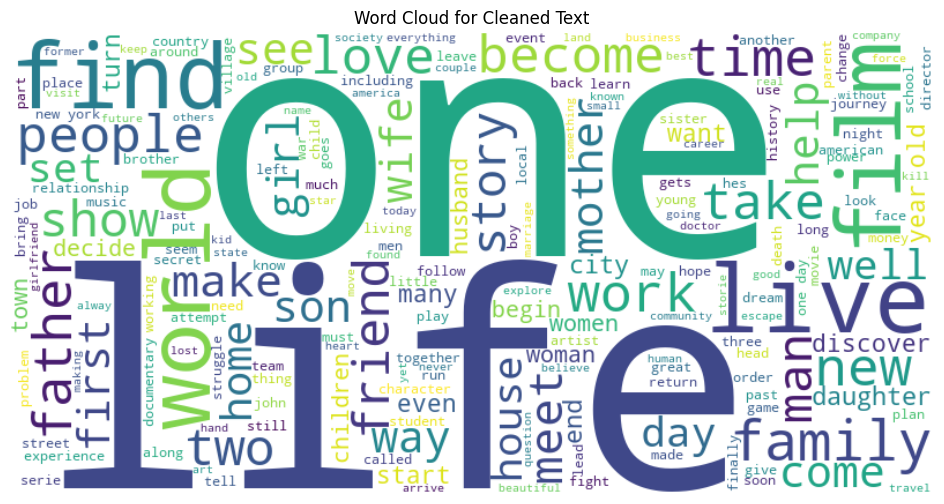

In [10]:
# Visualize word cloud for cleaned text
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, random_state=42, background_color='white').generate(' '.join(train_data['Text_cleaning']))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Cleaned Text')
plt.axis('off')
plt.show()

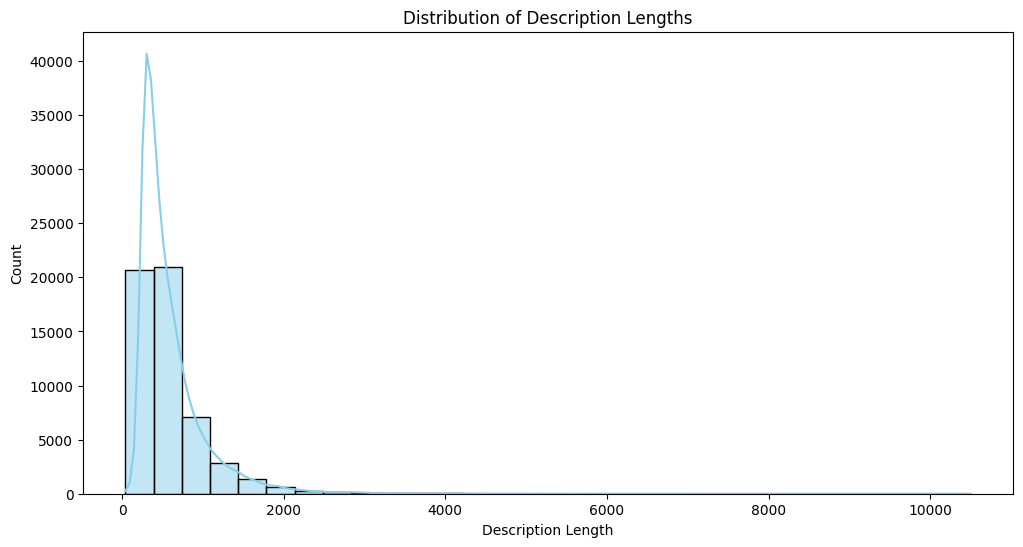

In [11]:

train_data['Description_Length'] = train_data['Description'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(train_data['Description_Length'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Description Lengths')
plt.xlabel('Description Length')
plt.ylabel('Count')
plt.show()

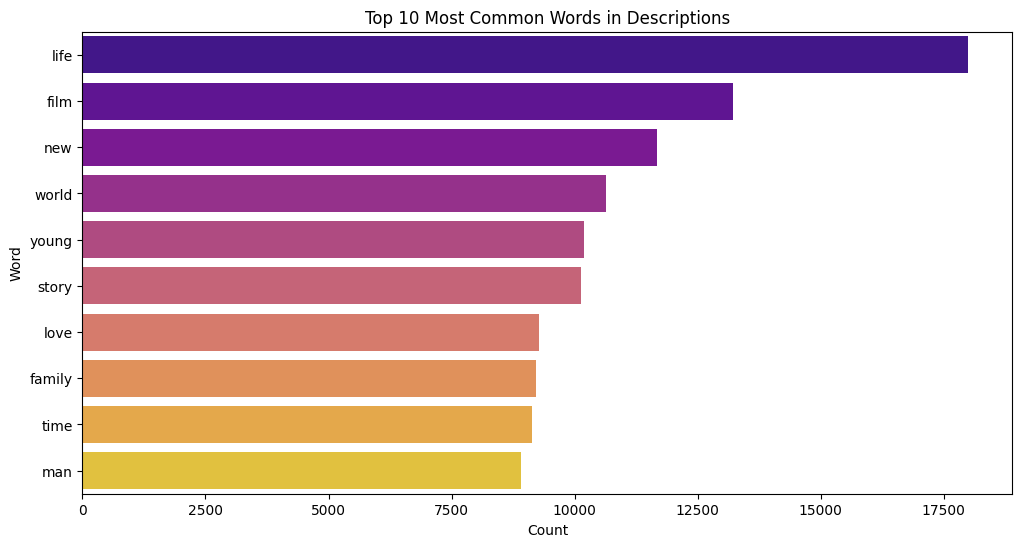

In [12]:
# Use CountVectorizer to get the most common words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=10)
description_matrix = vectorizer.fit_transform(train_data['Text_cleaning'])
word_counts = description_matrix.sum(axis=0)
feature_names = vectorizer.get_feature_names_out()

top_words_df = pd.DataFrame({'Word': feature_names, 'Count': word_counts.flat})
top_words_df = top_words_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=top_words_df, palette='plasma')
plt.title('Top 10 Most Common Words in Descriptions')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

In [13]:
# Initialize and train a Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred, zero_division=0.0))


Validation Accuracy: 0.579728857327308
               precision    recall  f1-score   support

      action        0.61      0.22      0.32       263
       adult        0.86      0.17      0.28       112
   adventure        0.45      0.10      0.16       139
   animation        0.67      0.02      0.04       104
   biography        0.00      0.00      0.00        61
      comedy        0.52      0.59      0.55      1443
       crime        1.00      0.01      0.02       107
 documentary        0.65      0.87      0.74      2659
       drama        0.53      0.81      0.64      2697
      family        0.50      0.05      0.10       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.92      0.30      0.45        40
     history        0.00      0.00      0.00        45
      horror        0.67      0.55      0.60       431
       music        0.71      0.38      0.49       144
     musical        0.00      0.00      0.00        50
     mystery        0.00 

In [ ]:
# User input for genre prediction
user_input = input("Enter a movie description: ")

if not user_input.strip():
    print("Please enter a valid movie description.")
else:
    cleaned_input = clean_text(user_input)
    tfidf_input = tfidf_vectorizer.transform([cleaned_input])
    predicted_genre = classifier.predict(tfidf_input)[0]

    # Get predicted probabilities for each genre
    genre_probs = classifier.predict_proba(tfidf_input)[0]
    top_predicted_genres = classifier.classes_[genre_probs.argsort()[::-1][:3]]  # Display top 3 genres

    print("\nPredicted Genre:", predicted_genre)
    print("Top Predicted Genres:", ', '.join(top_predicted_genres))
    print("Genre Probabilities:", ', '.join([f"{genre}: {prob:.2f}" for genre, prob in zip(classifier.classes_, genre_probs)]))
